H2: A learner performs better later than earlier in the collaborative activities. 

* H2.1: A learner submits better solutions later than earlier.
* H2.2: A learner suggests optimal actions more later than earlier.
* H2.3: A learner (dis)agrees more with (sub)optimal suggestions later than earlier.


For H2.1: Compare errors of best attempt in activity 1 and best attempt in activity 2 by Wilcoxon’s, and compute effect size by Cliff’s Delta.

## Initialization

In [1]:
import math
import copy
import pickle

import pathlib as pl
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter, AutoMinorLocator
import matplotlib.transforms as mtrans

import seaborn as sns
import numpy as np

from scipy.stats import wilcoxon, shapiro, stats
from effsize.effsize import two_group_difference

from justhink_world import create_all_worlds
from justhink_world.agent import Agent
from justhink_world.domain.action import *
from justhink_world.tools.network import compute_total_cost, is_subgraph_spanning

from utils import plot_comparison, pick_colors, draw_network

In [2]:
# Switch to Type 1 Fonts. 
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
# matplotlib.rcParams['text.usetex'] = True

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
# Visuals in paper theme, with larger font and thicker lines.
# sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 2.5})

### Define paths.

In [5]:
# Inputs.
transitions_pickle_file = pl.Path(
    '../processed_data/justhink21_transitions.pickle')
submissions_pickle_file = pl.Path(
    '../processed_data/justhink21_submissions.pickle')
learning_file = pl.Path(
    '../processed_data/justhink21_learning_outcomes.csv')

# Outputs.
annot_transitions_pickle_file = pl.Path(
    '../processed_data/justhink21_transitions_annotated.pickle')

figs_dir = pl.Path('../figures')
perf_best_fig_file = figs_dir.joinpath('performance_best.pdf')
perf_extrema_fig_file = figs_dir.joinpath('performance_first_to_last.pdf')
evolution_fig_file = figs_dir.joinpath('performance_evolution.pdf')
action_quality_fig_file = figs_dir.joinpath('quality_actions.pdf')

performance_file = pl.Path(
    '../processed_data/justhink21_task_performance.csv')

### Load submission tables.

In [6]:
with submissions_pickle_file.open('rb') as handle:
    submissions = pickle.load(handle)

# Example:
submissions_df = submissions['all'].reset_index(drop=True)
submissions_df.head()

,participant,time,activity,state,next_state,action,attempt_no,cost,opt_cost,error,is_mst,is_spanning
0,1,161.277439,pretest-1,"Situation(Network(|E'|=7 in G(|V|=7, |E|=12)) ...","Situation(Network(|E'|=7 in G(|V|=7, |E|=12)) ...","Action(submit,Human)",1,23,15,0.533333,False,True
1,1,251.009743,pretest-2,"Situation(Network(|E'|=7 in G(|V|=7, |E|=12)) ...","Situation(Network(|E'|=7 in G(|V|=7, |E|=12)) ...","Action(submit,Human)",1,38,30,0.266667,False,True
2,1,319.224974,pretest-3,"Situation(Network(|E'|=6 in G(|V|=7, |E|=12)) ...","Situation(Network(|E'|=6 in G(|V|=7, |E|=12)) ...","Action(submit,Human)",1,22,21,0.047619,False,True
3,1,386.282414,pretest-4,"Situation(Network(|E'|=6 in G(|V|=7, |E|=12)) ...","Situation(Network(|E'|=6 in G(|V|=7, |E|=12)) ...","Action(submit,Human)",1,45,45,0.000000,True,True
4,1,435.368411,pretest-5,"Situation(Network(|E'|=6 in G(|V|=7, |E|=12)) ...","Situation(Network(|E'|=6 in G(|V|=7, |E|=12)) ...","Action(submit,Human)",1,15,15,0.000000,True,True


### Load transition tables.

In [7]:
with transitions_pickle_file.open('rb') as handle:
    transitions = pickle.load(handle)


# Example:
transitions.keys()
pd.options.display.max_columns = None
df = transitions[9]
df = df.loc[df['activity'] == 'collaboration-2']
# df.head()

### Load activity instances.
Activities are represented in 'justhink_world' as worlds.

In [8]:
worlds = create_all_worlds()

# Consider the test and collaboration worlds.
worlds = {k: v for k, v in worlds.items() if 'test' in k or 'collab' in k}

# Example:
# Print information on the activities.
# The name of the activity.
# name = 'pretest-1'
name = 'collaboration-1'
# Background network connections and costs for that activity.
print(worlds[name].env.state.network.graph.edges(data=True))

[(3, 1, {'cost': 3}), (3, 0, {'cost': 3}), (3, 2, {'cost': 3}), (3, 5, {'cost': 4}), (3, 7, {'cost': 5}), (1, 9, {'cost': 3}), (1, 2, {'cost': 2}), (1, 5, {'cost': 4}), (1, 4, {'cost': 3}), (0, 2, {'cost': 5}), (0, 7, {'cost': 4}), (2, 9, {'cost': 4}), (2, 8, {'cost': 3}), (5, 4, {'cost': 2}), (5, 7, {'cost': 3}), (5, 6, {'cost': 4}), (4, 9, {'cost': 3}), (4, 6, {'cost': 2}), (7, 6, {'cost': 2}), (9, 8, {'cost': 2})]


### Load learning outcomes table.

In [9]:
learning_df = pd.read_csv(learning_file, index_col=0)
learning_df

,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error,pretest_errors,posttest_errors,gain_feasible,gain_optimal,learning_gain
participant,,,,,,,,,,,
1,1.0,1.0,0.4,0.8,0.169524,0.013333,"[0.5333333333333333, 0.26666666666666666, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.06666666666666667]",0.0,0.666667,0.156190
2,0.8,1.0,0.0,0.8,0.310476,0.009524,"[nan, 0.6, 0.2857142857142857, 0.2, 0.46666666...","[0.0, 0.0, 0.047619047619047616, 0.0, 0.0]",1.0,0.800000,0.300952
3,1.0,1.0,0.2,1.0,0.040635,0.000000,"[0.06666666666666667, 0.06666666666666667, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.0,1.000000,0.040635
4,0.8,1.0,0.0,0.0,0.389841,0.355556,"[nan, 1.2666666666666666, 0.23809523809523808,...","[0.2, 0.4, 0.3333333333333333, 0.5111111111111...",1.0,NaN,0.034286
5,1.0,0.8,0.0,0.0,0.300317,0.166984,"[0.4666666666666667, 0.26666666666666666, 0.19...","[0.26666666666666666, nan, 0.19047619047619047...",-0.2,NaN,0.133333
6,1.0,0.8,0.0,0.0,0.309841,0.149841,"[0.26666666666666666, 0.5333333333333333, 0.23...","[nan, 0.26666666666666666, 0.23809523809523808...",-0.2,NaN,0.160000
7,0.4,0.0,0.2,0.0,0.040000,NaN,"[0.2, 0.0, nan, nan, nan]","[nan, nan, nan, nan, nan]",-1.0,-1.000000,NaN
8,1.0,1.0,0.0,0.0,0.925714,0.103492,"[0.2, 1.6, 1.4285714285714286, 1.2, 0.2]","[0.13333333333333333, 0.2, 0.09523809523809523...",0.0,NaN,0.822222
9,1.0,1.0,0.8,0.8,0.013333,0.009524,"[0.06666666666666667, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.047619047619047616, 0.0, 0.0]",0.0,0.000000,0.003810


## Processing

### Annotate human and best submissions.

In [10]:
# Annotate human submissions.
submissions_df['is_human'] = \
    [action.agent == Agent.HUMAN for action in submissions_df.action]

# Annotate best submissions of each activity.
# (tests are trivial as there is only one submission allowed).
submissions_df['is_best'] = False
for p in submissions_df.participant.unique():
    df = submissions_df[submissions_df.participant == p]
    for a in df.activity.unique():
        dff = df[df.activity == a]
        min_index = dff.error.idxmin()
        if not math.isnan(min_index):
            submissions_df.loc[min_index, 'is_best'] = True

# Check if all best submissions are human.
for i, row in submissions_df.iterrows():
    if row.is_best:
        assert row.is_human


# submissions_df.head()

### Annotate first and last submissions.

In [11]:
# Annotate first and last submissions of each activity.
# (tests are trivial as there is only one submission allowed).
submissions_df['is_first'] = False
submissions_df['is_last'] = False
for p in submissions_df.participant.unique():
    df = submissions_df[submissions_df.participant == p]
    for a in df.activity.unique():
        dff = df[df.activity == a]
        # Only consider the human submissions.
        dff = dff[dff.is_human]
        
        min_index = dff.index[0]
        submissions_df.loc[min_index, 'is_first'] = True

        max_index = dff.index[-1]
        submissions_df.loc[max_index, 'is_last'] = True

### Make a performance table for the collaborative activities.

In [12]:
df = submissions_df.copy()
df = df[df.is_best]
collab_activities = ['collaboration-1', 'collaboration-2']
df = df[df.activity.isin(collab_activities)]
df.drop(columns=['is_best', 'is_human'], inplace=True)
# col_activity_no =
df = df.pivot(index='participant', columns='activity')
df = df[['attempt_no', 'error', 'is_mst', 'is_spanning']]
performance_df = df

performance_df

attempt_no                           error                  \
activity    collaboration-1 collaboration-2 collaboration-1 collaboration-2   
participant                                                                   
1                       2.0             3.0        0.318182        0.000000   
2                       1.0             6.0        0.000000        0.000000   
3                       3.0             2.0        0.000000        0.057143   
4                       2.0             3.0        0.318182        0.000000   
5                       3.0             1.0        0.318182        0.000000   
6                       1.0             1.0        0.772727        0.542857   
7                       2.0             NaN        0.000000             NaN   
8                       3.0             2.0        0.045455        0.000000   
9                       1.0             1.0        0.000000        0.000000   

                     is_mst                     is_spanning                  
activity    collaboration-1 collaboration-2 collaboration-1 collaboration-2  
participant                                                                  
1                     False            True            True            True  
2                      True            True            True            True  
3                      True           False            True            True  
4                     False            True            True            True  
5                     False            True            True            True  
6                     False           False            True            True  
7                      True             NaN            True             NaN  
8                     False            True            True            True  
9                      True            True            True            True

In [13]:
# a Simplified version for plotting.

df = submissions_df.copy()
# Check if all best submissions are human.
for i, row in df.iterrows():
    if row.is_best:
        assert row.is_human
cols = ['participant', 'activity', 'error', 'attempt_no', 'is_best']
df = df[cols]
df = df[df.is_best]
df.drop(columns=['is_best'], inplace=True)
# df.set_index('participant', inplace=True)
# df.pivot('participant', columns='activity') #, inplace=True)
best_submissions_df = df
submissions['best'] = best_submissions_df

best_submissions_df.head()

,participant,activity,error,attempt_no
0,1,pretest-1,0.533333,1
1,1,pretest-2,0.266667,1
2,1,pretest-3,0.047619,1
3,1,pretest-4,0.000000,1
4,1,pretest-5,0.000000,1


### Make a first-last submissions table.

In [14]:
df = submissions_df.copy()
# Get the first of activity 1 and last of activity 2.
df = df[
    (df.is_first & (df.activity == 'collaboration-1')) | \
    (df.is_last & (df.activity == 'collaboration-2'))]
comp_df = df
# comp_df.drop(columns=['is_best', 'is_human'], inplace=True)
comp_df = comp_df.pivot(index='participant', columns='activity')

comp_df[['error', 'is_mst', 'is_spanning', 'attempt_no']]

error                          is_mst                  \
activity    collaboration-1 collaboration-2 collaboration-1 collaboration-2   
participant                                                                   
1                  0.318182        0.000000           False            True   
2                  0.000000        0.000000            True            True   
3                  0.318182        0.114286           False           False   
4                  0.454545        0.000000           False            True   
5                  0.318182        0.000000           False            True   
6                  0.772727             NaN           False           False   
7                       NaN             NaN           False           False   
8                  0.454545        0.000000           False            True   
9                  0.000000        0.000000            True            True   

                is_spanning                      attempt_no                  
activity    collaboration-1 collaboration-2 collaboration-1 collaboration-2  
participant                                                                  
1                      True            True               2               3  
2                      True            True               1               6  
3                      True            True               2               3  
4                      True            True               1               3  
5                      True            True               3               1  
6                      True           False               1               4  
7                     False           False               1               4  
8                      True            True               1               2  
9                      True            True               1               1

In [15]:
activity_renamer = dict()
for a in submissions_df.activity.unique():
    new = a
    new = new.replace('test', '')
    new = new.replace('collaboration', 'collab')
    activity_renamer[a] = new

# activity_renamer

### Annotate the quality of actions.

#### Construct optimal solutions.

In [16]:
# subgraph.add_edge(2, 8, cost=cost) # instead of 1, 9 or 4, 9
# subgraph.add_edge(2, 3, cost=cost) # instead of 1, 3
# subgraph.add_edge(9, 4, cost=cost)
# graph.remove_edge(1, 9)

In [17]:
import networkx as nx

In [18]:
# G1 = nx.Graph()
# G2 = nx.Graph()
# G1.add_edge(1,2)
# G2.add_edge(2, 1)
# G1 == G2
# s = set()
# s.add(G1)
# s.add(G2)
# s
# G1.edges() == G2.edges()
# G1.edges(), G2.edges()

collaboration-1 10 20
9 edges cost: 22 True
9 edges cost: 22 True
9 edges cost: 22 True
9 edges cost: 22 True
9 edges cost: 22 True
9 edges cost: 22 True
9 edges cost: 22 True
9 edges cost: 22 True
9 edges cost: 22 True
9 edges cost: 22 True
collaboration-2 10 20
9 edges cost: 35 True
9 edges cost: 35 True
9 edges cost: 35 True
9 edges cost: 35 True
9 edges cost: 35 True
9 edges cost: 35 True
9 edges cost: 35 True
9 edges cost: 35 True
9 edges cost: 35 True
9 edges cost: 35 True
pretest-1 7 12
6 edges cost: 15 True
pretest-2 7 12
6 edges cost: 30 True
pretest-3 7 12
6 edges cost: 21 True
pretest-4 7 12
6 edges cost: 45 True
pretest-5 7 12
6 edges cost: 15 True


/tmp/ipykernel_49480/3171746954.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))


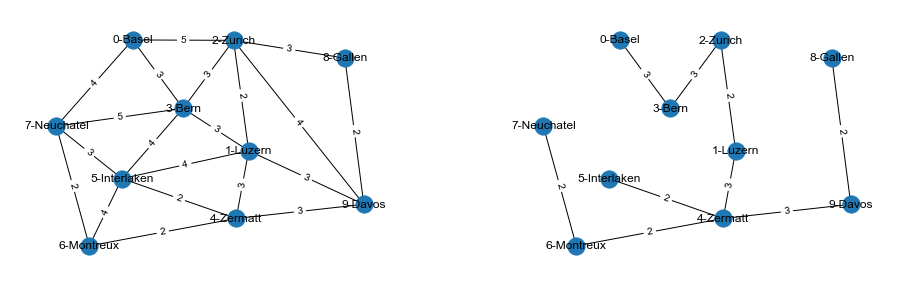

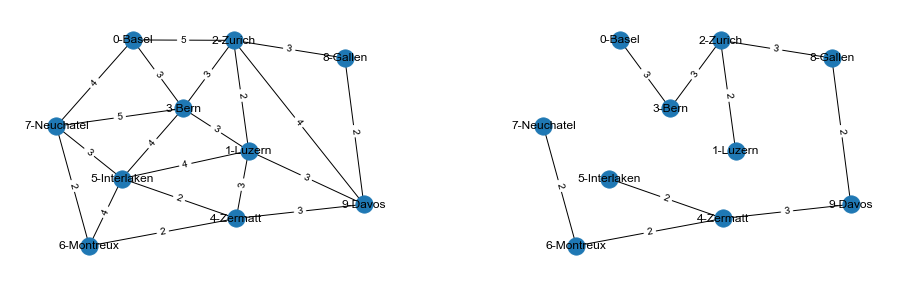

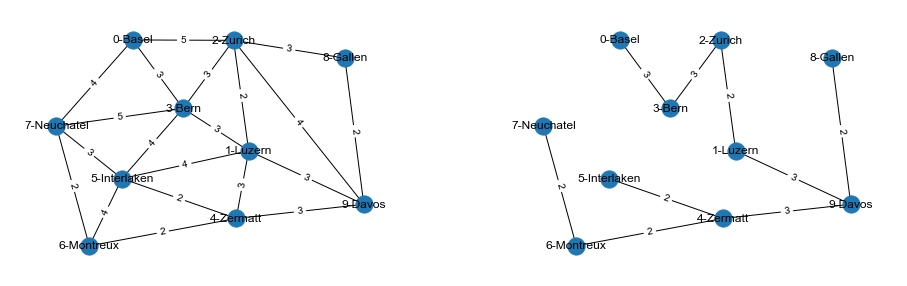

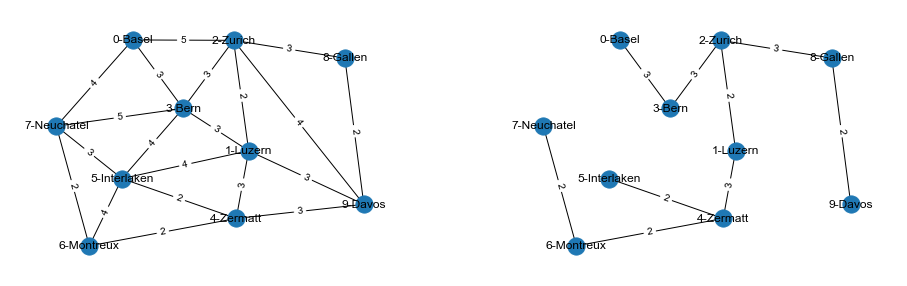

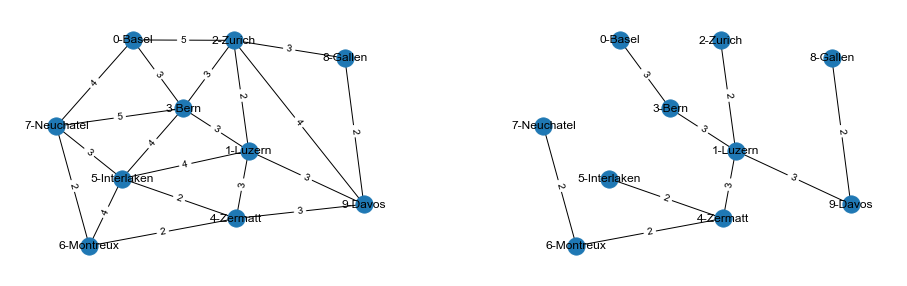

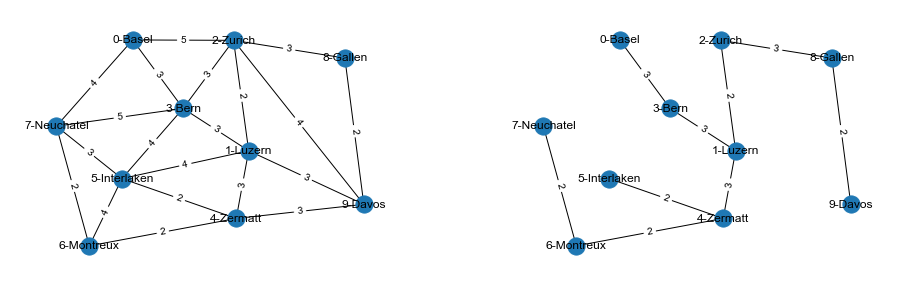

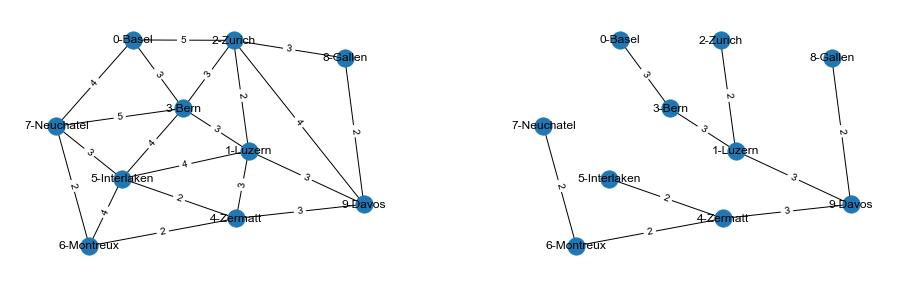

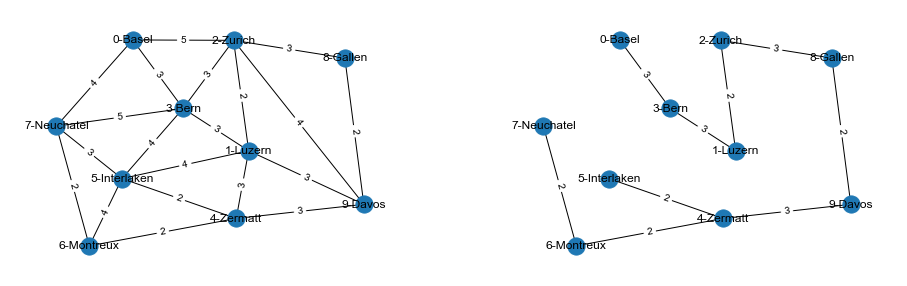

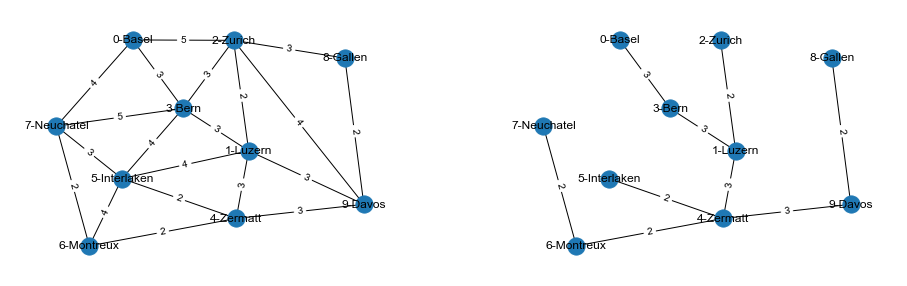

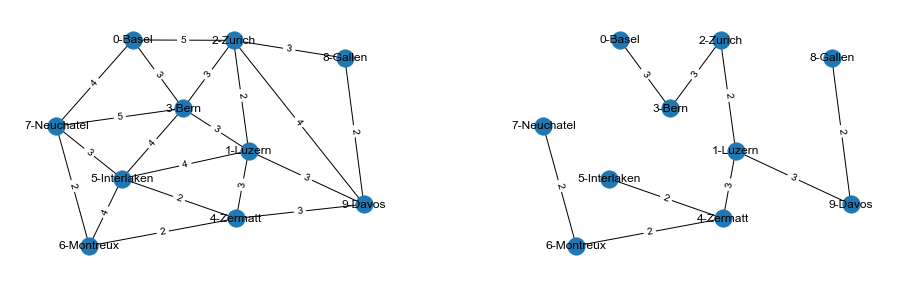

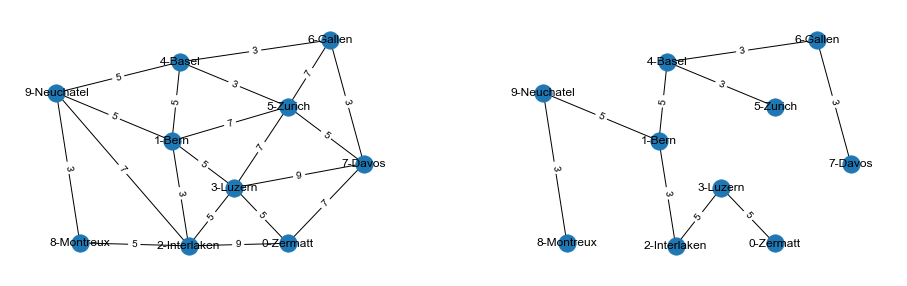

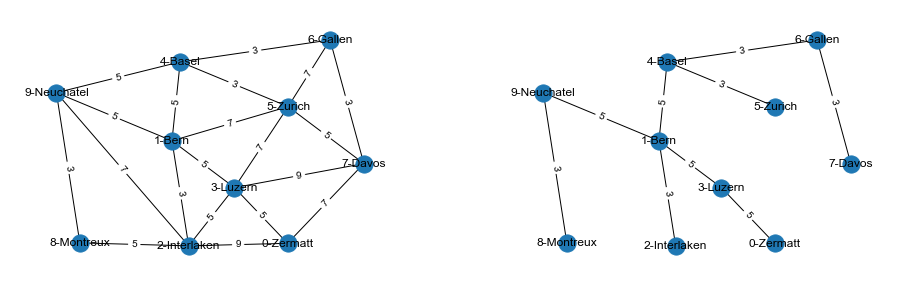

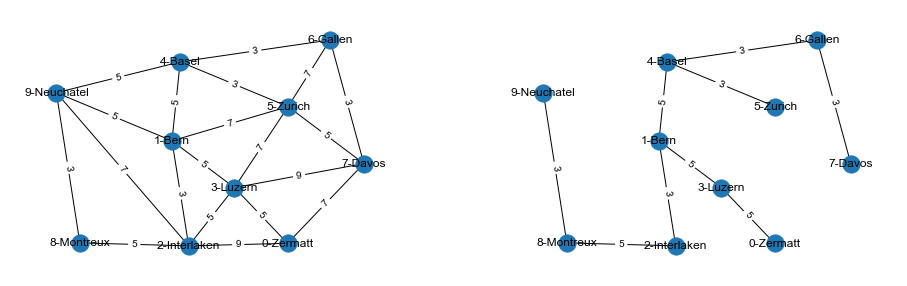

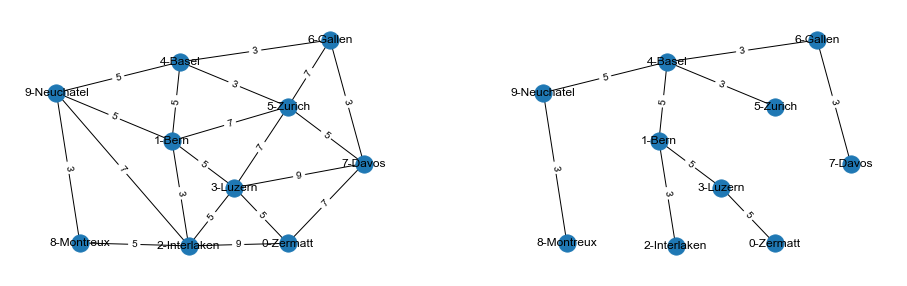

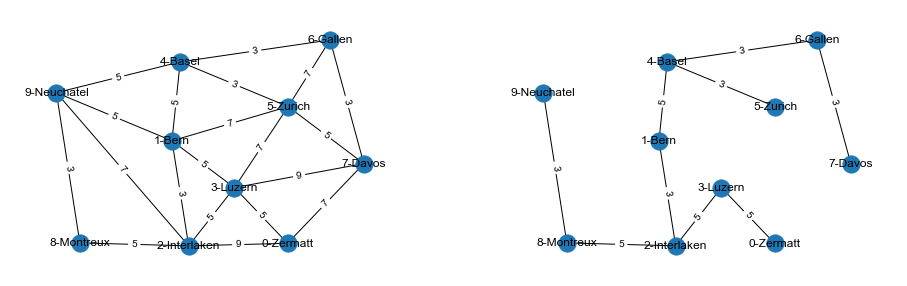

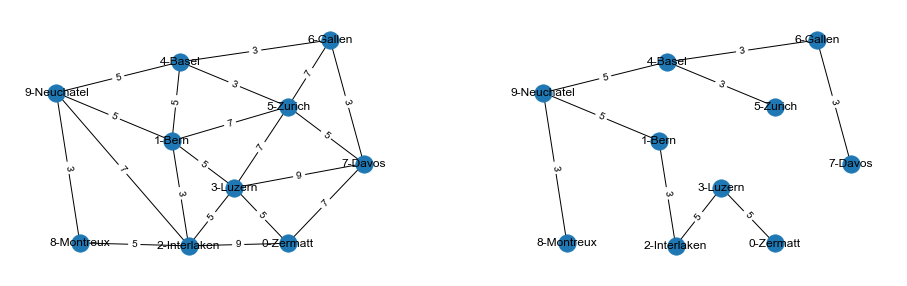

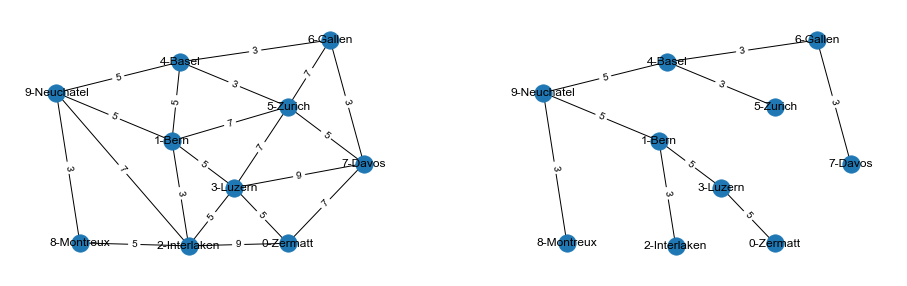

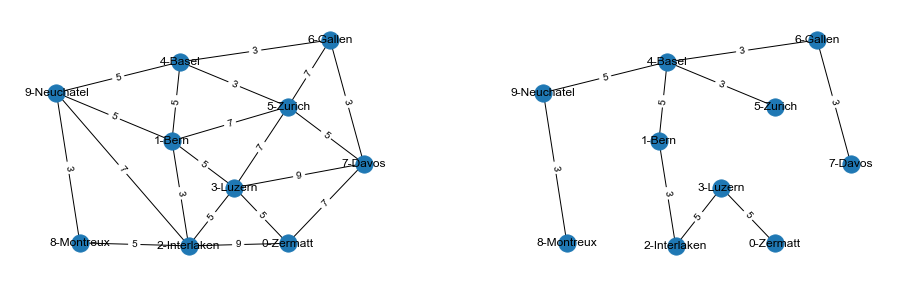

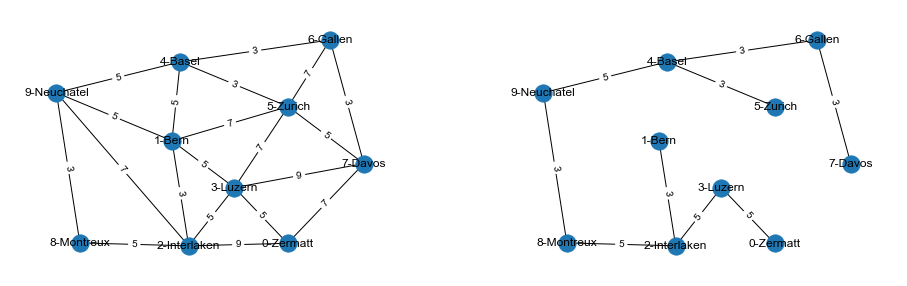

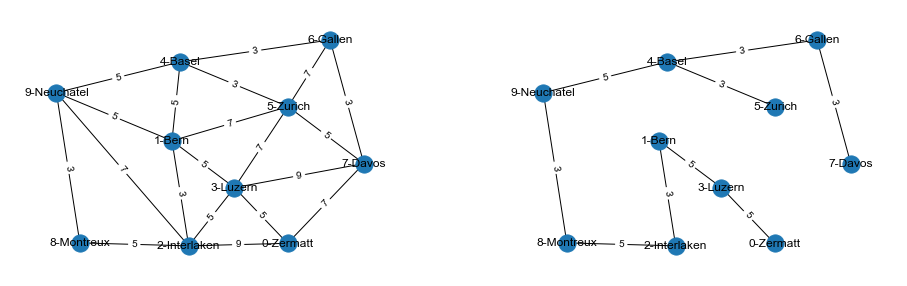

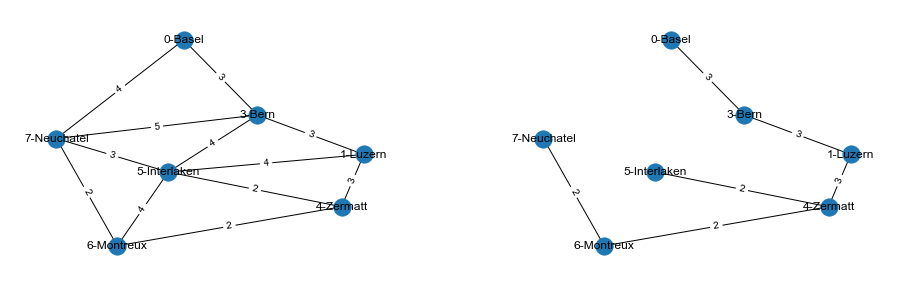

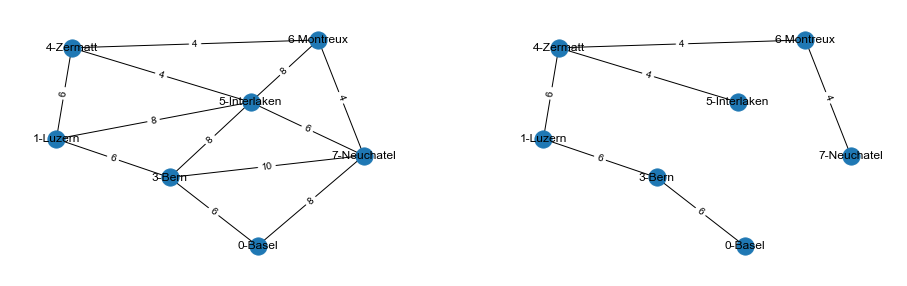

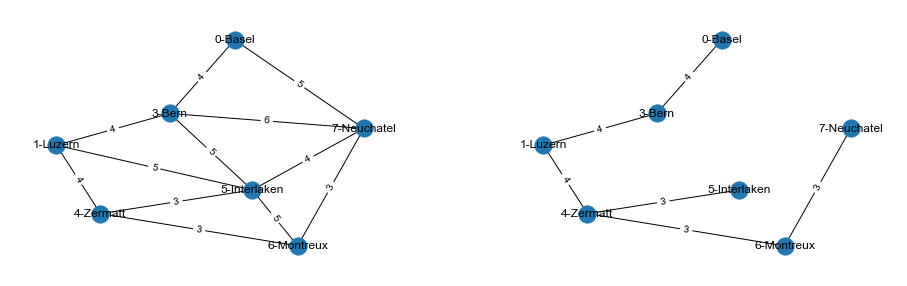

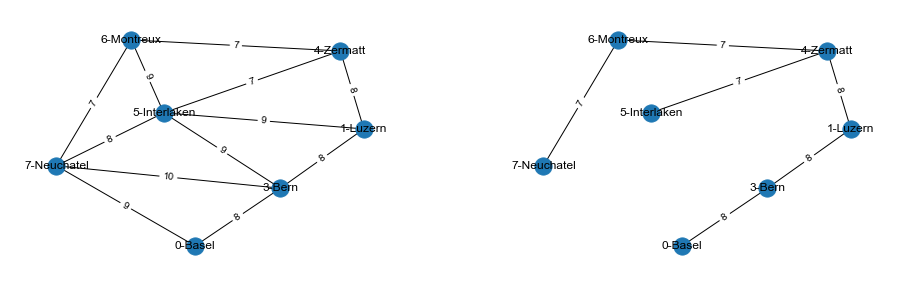

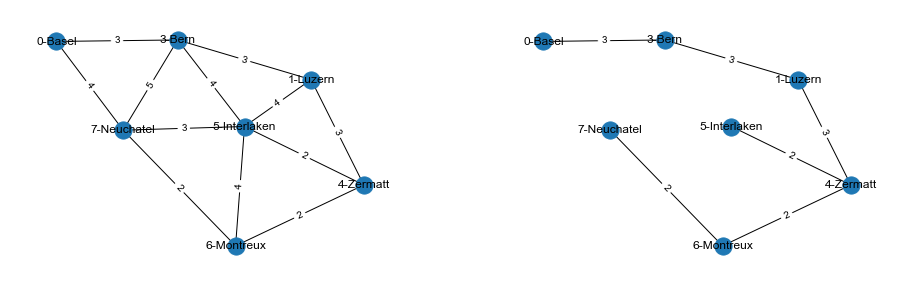

In [19]:
optimal_graphs = dict()

edges1 = {(2, 3), (1, 3)}
edges2 = {(1, 9), (4, 9), (2, 8)}
edges3 = {(1, 9), (1, 4), (2, 8)} # if 4,9

for activity in sorted(worlds):
    optimal_graphs[activity] = set()
    if 'pretest' in activity or 'collab' in activity:

        network = worlds[activity].env.state.network
        subgraph = network.get_mst()
        if 'collab' in activity:

            # for edges in [edges1, edges2, edges3]:
            for edge1 in edges1:
                for edge2 in edges2:
                    g = subgraph.copy()
                    for u, v in edges1.union(edges2):
                        if g.has_edge(u, v):
                            g.remove_edge(u, v)

                    if activity == 'collaboration-1':
                        cost = 3
                    else:
                        cost = 5

                    g.add_edge(edge1[0], edge1[1], cost=cost)
                    g.add_edge(edge2[0], edge2[1], cost=cost)

                    optimal_graphs[activity].add(g)
                    
            for gg in set(optimal_graphs[activity]):
                if gg.has_edge(4, 9) and gg.has_edge(1, 4):
                    count = 0
                    for edge in edges3:
                        if gg.has_edge(*edge):
                            count = count + 1
                    
                    if count == 1:
                        for edge in edges3:
                            # gg = subgraph.copy()
                            g = gg.copy()
                            
                            # print('Removed')
                            # for u, v in edges3:
                            #     if g.has_edge(u, v):
                            #         g.remove_edge(u, v)
                            
                            g.remove_edge(1, 4)
                            g.add_edge(edge[0], edge[1], cost=cost)

                            is_added = False
                            for added_g in optimal_graphs[activity]:
                                if added_g.edges() == g.edges():
                                    is_added = True
                            if not is_added:
                                optimal_graphs[activity].add(g)

        else:
            optimal_graphs[activity].add(subgraph)

        print(activity, network.graph.number_of_nodes(),
              network.graph.number_of_edges())

        for subgraph in optimal_graphs[activity]:
            print(subgraph.number_of_edges(),  'edges',
                  'cost:', compute_total_cost(subgraph),
                  is_subgraph_spanning(subgraph, subgraph))
            fig, axs = plt.subplots(1, 2, figsize=(16, 5))
            draw_network(network.graph, ax=axs[0])
            draw_network(subgraph, ax=axs[1])


# for name, subgraph in optimal_graphs.items():
#     print(name)
#     draw_network(subgraph)

In [20]:
graphs = list(optimal_graphs['collaboration-1'])

for i, g in enumerate(graphs):
    for j in range(i+1, len(graphs)):
        s1 = set(g.edges())
        s2 = set(graphs[j].edges())
        print(i, j, compute_total_cost(g), s1 == s2, '!!!', s1 - s2, '!!!', s2 - s1) #g.edges() == graphs[j].edges(), g.edges().)

0 1 22 False !!! {(1, 4)} !!! {(2, 8)}
0 2 22 False !!! {(1, 4)} !!! {(1, 9)}
0 3 22 False !!! {(4, 9)} !!! {(2, 8)}
0 4 22 False !!! {(4, 9), (3, 2)} !!! {(3, 1), (1, 9)}
0 5 22 False !!! {(4, 9), (3, 2)} !!! {(3, 1), (2, 8)}
0 6 22 False !!! {(3, 2), (1, 4)} !!! {(3, 1), (1, 9)}
0 7 22 False !!! {(3, 2), (1, 4)} !!! {(3, 1), (2, 8)}
0 8 22 False !!! {(3, 2)} !!! {(3, 1)}
0 9 22 False !!! {(4, 9)} !!! {(1, 9)}
1 2 22 False !!! {(2, 8)} !!! {(1, 9)}
1 3 22 False !!! {(4, 9)} !!! {(1, 4)}
1 4 22 False !!! {(4, 9), (3, 2), (2, 8)} !!! {(3, 1), (1, 9), (1, 4)}
1 5 22 False !!! {(4, 9), (3, 2)} !!! {(3, 1), (1, 4)}
1 6 22 False !!! {(3, 2), (2, 8)} !!! {(3, 1), (1, 9)}
1 7 22 False !!! {(3, 2)} !!! {(3, 1)}
1 8 22 False !!! {(3, 2), (2, 8)} !!! {(3, 1), (1, 4)}
1 9 22 False !!! {(4, 9), (2, 8)} !!! {(1, 9), (1, 4)}
2 3 22 False !!! {(4, 9), (1, 9)} !!! {(1, 4), (2, 8)}
2 4 22 False !!! {(4, 9), (3, 2)} !!! {(3, 1), (1, 4)}
2 5 22 False !!! {(4, 9), (3, 2), (1, 9)} !!! {(3, 1), (1, 4), (2, 

#### Annotate optimality of actions.

In [21]:
def annotate_optimality(transition_df, optimal_graphs):
    is_optimal_list = list()

    possible_optimals_list = list()

    for i, row in df.iterrows():
        optimals = None  # not applicable
        is_optimal = None

        activity = row['activity']
        if activity in optimal_graphs:

            subgraphs = optimal_graphs[activity]

            action = row['action']
            state = row['state']

            # Get the set of applicable optimal graphs.
            optimals = set()
            for subgraph in subgraphs:
                # print(activity, subgraph)
                is_possible = True
                for edge in state.network.subgraph.edges():
                    # print('edge', edge, 'in subgraph', subgraph)
                    if not subgraph.has_edge(*edge):
                        is_possible = False
                        break
                if is_possible:
                    optimals.add(subgraph)

            # return optimals
            suggested_edge = state.network.suggested_edge

            # For suggestions or picks (in tests).
            if isinstance(action, PickAction) or isinstance(action, SuggestPickAction):
                is_optimal = False
                for optimal_graph in optimals:
                    if optimal_graph.has_edge(*action.edge):
                        is_optimal = True

            # For agreements.
            elif isinstance(action, AgreeAction):
                if suggested_edge is None:
                    print('Log entry error for {} at time {}'.format(
                        row['participant'], row['time']))
                else:
                    # is_optimal = optimal_graph.has_edge(*suggested_edge)
                    # If any possible one has it.
                    is_optimal = False
                    for optimal_graph in optimals:
                        if optimal_graph.has_edge(*suggested_edge):
                            is_optimal = True

            # For disagreements.
            elif isinstance(action, DisagreeAction):
                if suggested_edge is None:
                    print('Log entry error for {} at time {}'.format(
                        row['participant'], row['time']))
                else:
                    # is_optimal = not optimal_graph.has_edge(*suggested_edge)
                    # If none of the possible ones have it.
                    is_optimal = True
                    for optimal_graph in optimals:
                        if optimal_graph.has_edge(*suggested_edge):
                            is_optimal = False

            # For submissions.
            elif isinstance(action, SubmitAction) or isinstance(action, AttemptSubmitAction):
                is_optimal = state.network.is_mst()

            elif isinstance(action, ContinueAction):
                is_optimal = not state.network.is_mst()

            # For clear actions.
            elif isinstance(action, ClearAction):
                # is_optimal = not state.network.is_mst()
                # If no optimal is possible from this point on.
                is_optimal = len(optimals) == 0

        possible_optimals_list.append(optimals)
        is_optimal_list.append(is_optimal)

#     return possible_optimals_list
    transition_df['possible_optimals'] = possible_optimals_list
    transition_df['is_optimal'] = is_optimal_list


# Test.
df = transitions[5].copy()
df = df[df.activity == 'collaboration-1']
# df.head(50)
annotate_optimality(df, optimal_graphs)

# df = df[df.activity == 'collaboration-1']
# df.head(50)

In [22]:
# optimal_graphs['collaboration-1'].edge

In [23]:
for participant, df in transitions.items():
    annotate_optimality(df, optimal_graphs)

Log entry error for 3 at time 2097.803678750992
Log entry error for 4 at time 972.7352321147919
Log entry error for 6 at time 738.1626312732697
Log entry error for 8 at time 474.6776592731476


#### Annotate time in the activities.

In [24]:
for participant, df in transitions.items():
    df['time_in_activity'] = None #df['time']
    for activity in collab_activities:
        start = df[df.activity == activity].iloc[0]['time']
        for index in df[df.activity == activity].index:
            df.loc[index, 'time_in_activity'] = (df.loc[index, 'time'] - start) #  / 60.0

In [25]:
# df['time_in_activity'].max()

In [26]:
for participant, df in transitions.items():
    df['time_in_activity_frac'] = None
    for activity in collab_activities:
        duration = df[df.activity == activity]['time_in_activity'].max()
        print(participant, activity, duration)

        for index in df[df.activity == activity].index:
            df.loc[index, 'time_in_activity_frac'] = df.loc[index, 'time_in_activity'] / duration

1 collaboration-1 1021.5548250675201
1 collaboration-2 885.7920482158661
2 collaboration-1 971.7683861255646
2 collaboration-2 752.2715554237366
3 collaboration-1 1160.3446493148804
3 collaboration-2 1115.3263137340546
4 collaboration-1 1716.553304195404
4 collaboration-2 693.9256730079651
5 collaboration-1 1631.7320919036865
5 collaboration-2 441.394987821579
6 collaboration-1 1508.1606903076172
6 collaboration-2 1121.7858850955963
7 collaboration-1 566.0695028305054
7 collaboration-2 1179.0049033164978
8 collaboration-1 1537.6577711105347
8 collaboration-2 495.552969455719
9 collaboration-1 444.052942276001
9 collaboration-2 318.3162956237793


### Merge transitions tables into one table.

In [27]:
# Annotate human submissions.
submissions_df['is_human'] = \
    [action.agent == Agent.HUMAN for action in submissions_df.action]

### Merge transitions tables into one table.

In [28]:
transitions_df = pd.concat([transitions[participant] for participant in sorted(transitions)])

transitions_df.head(5) #50)

,participant,time,activity,state,next_state,action,attempt_no,cost,opt_cost,error,is_submission,is_mst,is_spanning,possible_optimals,is_optimal,time_in_activity,time_in_activity_frac
0,1,0.000000,tutorial,"Situation(Network(|E'|=0 in G(|V|=2, |E|=1)) w...","Situation(Network(|E'|=1 in G(|V|=2, |E|=1)) w...","Action(pick(1,9),Human)",1,0,3,NaN,False,False,False,None,None,None,None
1,1,36.886868,tutorial,"Situation(Network(|E'|=1 in G(|V|=2, |E|=1)) w...","Situation(Network(|E'|=0 in G(|V|=2, |E|=1)) w...","Action(clear,Human)",1,3,3,0.0,False,True,True,None,None,None,None
2,1,54.157379,tutorial,"Situation(Network(|E'|=0 in G(|V|=2, |E|=1)) w...","Situation(Network(|E'|=1 in G(|V|=2, |E|=1)) w...","Action(pick(1,9),Human)",1,0,3,NaN,False,False,False,None,None,None,None
3,1,56.384898,tutorial,"Situation(Network(|E'|=1 in G(|V|=2, |E|=1)) w...","Situation(Network(|E'|=1 in G(|V|=2, |E|=1)) w...","Action(submit,Human)",1,3,3,0.0,False,True,True,None,None,None,None
4,1,96.414340,pretest-1,"Situation(Network(|E'|=0 in G(|V|=7, |E|=12)) ...","Situation(Network(|E'|=1 in G(|V|=7, |E|=12)) ...","Action(pick(7,0),Human)",1,0,15,NaN,False,False,False,"{(3, 1, 0, 5, 4, 7, 6)}",False,None,None


### Annotate human actions.

In [29]:
transitions_df['is_human'] = \
    [action.agent == Agent.HUMAN for action in transitions_df.action]

### Compute statistics on the duration of the activities.

In [30]:
for activity in collab_activities:
    df = transitions_df.copy()
    df = df[df.activity.isin([activity])]
    durations = df.groupby('participant')['time_in_activity'].apply(np.max).sort_values()

    print(activity, durations.sum() / 60, durations.mean() / 60, durations.std() / 60)

collaboration-1 175.9649027188619 19.551655857651323 7.7156758247485175
collaboration-2 116.72284386157989 12.969204873508877 5.324603658989846


### Export the task performance table in CSV data format.

In [31]:
# Simplify the column names.
df = performance_df.copy()
df.columns = ['_'.join(a).replace('collaboration-', '') for a in df.columns.to_flat_index()]
df['performance_gain'] = -(df['error_2'] - df['error_1'])
df

,attempt_no_1,attempt_no_2,error_1,error_2,is_mst_1,is_mst_2,is_spanning_1,is_spanning_2,performance_gain
participant,,,,,,,,,
1,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182
2,1.0,6.0,0.000000,0.000000,True,True,True,True,-0.000000
3,3.0,2.0,0.000000,0.057143,True,False,True,True,-0.057143
4,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182
5,3.0,1.0,0.318182,0.000000,False,True,True,True,0.318182
6,1.0,1.0,0.772727,0.542857,False,False,True,True,0.229870
7,2.0,NaN,0.000000,NaN,True,NaN,True,NaN,NaN
8,3.0,2.0,0.045455,0.000000,False,True,True,True,0.045455
9,1.0,1.0,0.000000,0.000000,True,True,True,True,-0.000000


In [32]:
### Export the task performance table in CSV data format.# Export.
df.to_csv(performance_file)
print('Saved task performance table to {}'.format(performance_file))

Saved task performance table to ../processed_data/justhink21_task_performance.csv


### Export the transitions table in pickle data format.

In [33]:
with annot_transitions_pickle_file.open('wb') as handle:
    pickle.dump(transitions_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Saved the transitions table to {}'.format(annot_transitions_pickle_file))

Saved the transitions table to ../processed_data/justhink21_transitions_annotated.pickle


## Hypothesis Testing

### Check H2.1: A learner submits better solutions later than earlier.

#### Check the difference between the first and last submissions.

Perform Wilcoxon signed-rank test and compute the effect size (estimated by Cliff's delta).

In [34]:
# Define function to retrieve and plot the feasible scores.
def get_errors_from_row(row):
    e1 = row['error']['collaboration-1']
    e2 = row['error']['collaboration-2']
    return (e1, e2)


def check_difference(df):
    r, o, plist = list(), list(), list()
    r_noties, o_noties = list(), list()
    for i, row in df.iterrows():
        v1, v2 = get_errors_from_row(row)
        if v1 == v2:
            print('Found a tie for {}: {} = {}'.format(
                i, v1, v2))
        else:
            r_noties.append(v1)
            o_noties.append(v2)
            plist.append(i)
        r.append(v1)
        o.append(v2)
        

    print('Shapiro:')
    r_shapiro_result = shapiro(r)
    o_shapiro_result = shapiro(o)
    print('r({}): {}'.format(len(r), r_shapiro_result))
    print('o({}): {}'.format(len(o), o_shapiro_result))
    
    print('Wilcoxon signed-rank test for {} samples (no ties):'.format(len(r_noties)))
    print(plist)
    print('r:', ', '.join(['{:.3f}'.format(val) for val in r_noties]))
    print('o:', ', '.join(['{:.3f}'.format(val) for val in o_noties]))
    # Null hypothesis says they are the same:
    # if p val less than threshold, reject hypothesis and
    # conclude that activity 1 best and activity 2 best are different.
    w, p = wilcoxon(r_noties, o_noties, mode='exact')
    # w, p = wilcoxon(r, o, mode='exact')
    print('Exact:', 'W=', w, 'pvalue=', p)

    # Estimate effect size by Cliff's Delta.
    r, o = list(), list()
    for i, row in df.iterrows():
        v1, v2 = get_errors_from_row(row)
        r.append(v1)
        o.append(v2)
    d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
    print("Cliff's delta ({} samples) = {}".format(len(r), d))


check_difference(comp_df.dropna())

Found a tie for 2: 0.0 = 0.0
Found a tie for 9: 0.0 = 0.0
Shapiro:
r(7): ShapiroResult(statistic=0.8026725053787231, pvalue=0.0435309000313282)
o(7): ShapiroResult(statistic=0.4529709219932556, pvalue=4.135582003073068e-06)
Wilcoxon signed-rank test for 5 samples (no ties):
[1, 3, 4, 5, 8]
r: 0.318, 0.318, 0.455, 0.318, 0.455
o: 0.000, 0.114, 0.000, 0.000, 0.000
Exact: W= 0.0 pvalue= 0.0625
Cliff's delta (7 samples) = -0.6734693877551021


#### Check the difference between best submissions in collaborative activities.
Perform Wilcoxon signed-rank test and compute the effect size (estimated by Cliff's delta).

In [35]:
check_difference(performance_df.dropna())

Found a tie for 2: 0.0 = 0.0
Found a tie for 9: 0.0 = 0.0
Shapiro:
r(8): ShapiroResult(statistic=0.8012939691543579, pvalue=0.029552701860666275)
o(8): ShapiroResult(statistic=0.4747297763824463, pvalue=5.114766736369347e-06)
Wilcoxon signed-rank test for 6 samples (no ties):
[1, 3, 4, 5, 6, 8]
r: 0.318, 0.000, 0.318, 0.318, 0.773, 0.045
o: 0.000, 0.057, 0.000, 0.000, 0.543, 0.000
Exact: W= 2.0 pvalue= 0.09375
Cliff's delta (8 samples) = -0.375


### Check H2.2: A learner suggests optimal actions more later than earlier.
on the quality of suggestions.

In [36]:
def compute_combined_mean_median_sd(df, of, by='participant'):
    # Compute combined mean, median and SD.
    A = [np.array(l) for l in (df.groupby(by)[of].apply(list))]

    N = float(sum([i.size for i in A]))
    mean_ = sum([i.sum() for i in A])/N
    std_ = np.sqrt(sum([((i-mean_)**2).sum() for i in A])/N)
    # print('combined mean = {:.2%} , combined SD = {:.1%}'.format(mean_, std_))

    print('combined mean = {} , combined SD = {}'.format(mean_, std_))

    medians = [np.median(i) for i in A]
    mean_medians = np.mean(medians)
    # print('mean of the medians = {:.1%}'.format(mean_medians))
    print('mean of the medians = {}'.format(mean_medians))


df = transitions_df.copy()
df = df.dropna(subset=['is_optimal'])
df = df[[isinstance(a, SuggestPickAction) for a in df.action]]
df = df[df.is_optimal]

for activity in collab_activities:
    print(activity)
    dff = df[df.activity.isin([activity])]

    of = 'time_in_activity_frac'
    compute_combined_mean_median_sd(dff, of=of)

collaboration-1
combined mean = 0.5036218827143127 , combined SD = 0.3044840196306102
mean of the medians = 0.5064796683736278
collaboration-2
combined mean = 0.4910934385515772 , combined SD = 0.3110160325662047
mean of the medians = 0.4939046991886292


### Check H2.3: A learner (dis)agrees more with (sub)optimal suggestions later than earlier.

on the quality of (dis)agreements.

In [37]:
df = transitions_df.copy()
df = df.dropna(subset=['is_optimal'])
df = df[[isinstance(a, AgreeAction) or isinstance(a, DisagreeAction) for a in df.action]]
df = df[df.is_optimal]

for activity in collab_activities:
    print(activity)
    dff = df[df.activity.isin([activity])]

    of = 'time_in_activity_frac'
    compute_combined_mean_median_sd(dff, of=of)

collaboration-1
combined mean = 0.493167959076513 , combined SD = 0.3114130241117005
mean of the medians = 0.5004533044157243
collaboration-2
combined mean = 0.5370798300481666 , combined SD = 0.3137073419641755
mean of the medians = 0.5916225490167584


## Visualizations

### Plot the complete evolution of performance over submissions.

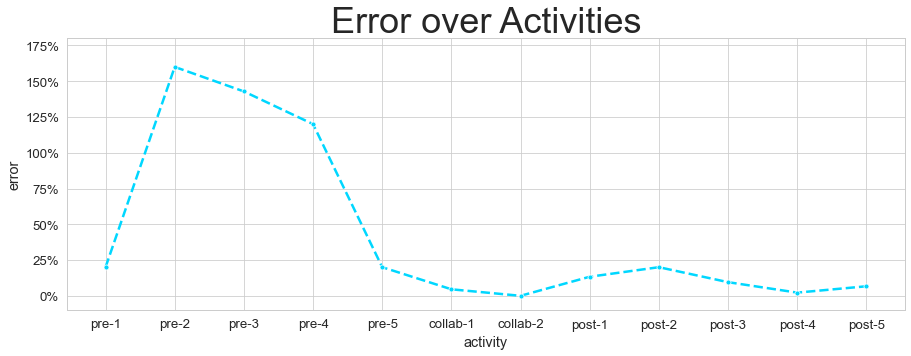

In [38]:
def plot_evolution(
        evolution_df, color, label,
        ax=None, ylabel='error', ylim=(-0.1, 1.8)):
    """helper function to graph each student dataframe 
    on same plot, takes dataframe as input"""
    temp = evolution_df

    if ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))

    # visualization for error evolution over the best submission in each collaborative activity
    # students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
    # separation = 0.01

    # graphing the pretest versus posttest is_spanning scores

    # Plot.
    size = 5
    marker = 'o'
    sns.lineplot(
        x=temp.activity, y=temp.error, marker=marker, ms=size,
        ls='--', color=color, label=label,
        legend=False, ax=ax)

    # title = 'Evolution of All Students'
    title = 'Error over Activities'

    ax.set_title(title, y=1.0, pad=-20) #, fontsize=36) #, loc='center', fontsize=20)
    ax.set_title(title, y=1.0, pad=-36, fontsize=36)
    ax.set_title(title, y=1.0, fontsize=36)

    # leg = plt.legend(evolution_dfs.keys(), loc='upper right', frameon=True)
    # # ensure that y-axis labelling is proportional to maximum possible error
    # plt.ylim(-0.1, 2.2)  # max_error[1])
    # locs, labels = plt.yticks()
    # labels = [str(round(i*100)) + '%' for i in locs]
    # labels[0] = ''
    # plt.yticks(locs, labels)

    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])


participant = 8
colors = pick_colors()
df = best_submissions_df.copy()
df = df[df.participant == participant]
df.activity = [activity_renamer[a] for a in df.activity]

plot_evolution(df, color=colors[participant], label=str(str(participant)))

In [39]:
sns.set_context('paper', font_scale=2.2, rc={"lines.linewidth": 2.5})

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif


../figures/performance_evolution.pdf


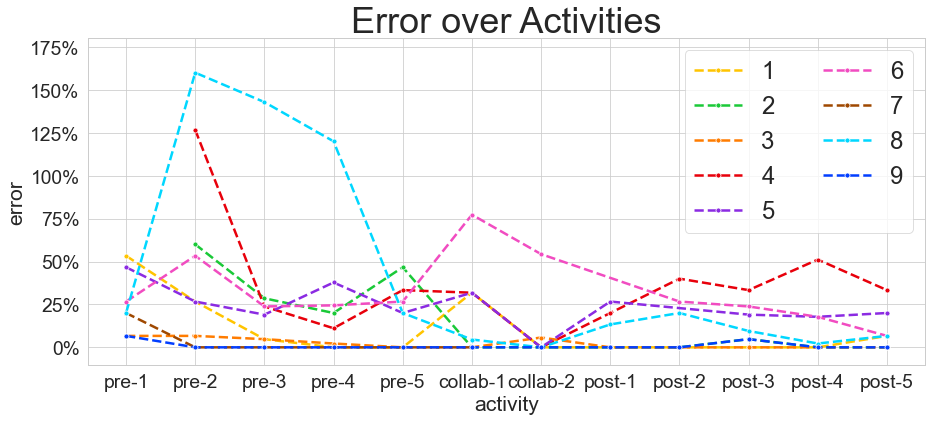

In [40]:
def plot_all_evolutions(submissions_df, export_file=None):
    participants = range(1, 10)  # [9, 1, 2, 3, 7, 4, 8, 5, 6]

    fig, ax = plt.subplots(1, figsize=(15, 6))  # 3

    colors = pick_colors()
    for p in participants:
        df = submissions_df.copy()
        df = df[df.participant == p]
        df.activity = [activity_renamer[a] for a in df.activity]

        plot_evolution(df, ax=ax, color=colors[p], label=str(str(p)))

    leg = plt.legend(sorted(participants), fontsize=24,
                     loc='upper right', frameon=True, ncol=2)

    # leg = plt.legend(sorted(participants), loc='upper left', frameon=True)
    # # Get the bounding box of the original legend.
    # bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    # # Change to location of the legend.
    # x_offset = 1.05
    # bb.x0 = bb.x0 + x_offset
    # bb.x1 = bb.x1 + x_offset
    # leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

    if export_file is not None:
        plt.savefig(export_file, bbox_inches='tight')
        print(export_file)


plot_all_evolutions(best_submissions_df, export_file=evolution_fig_file)

# submissions_df[['participant', 'activity', 'error']]
# plot_all_evolutions(submissions_df)

In [41]:
# sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 2.5})

### Plot first-last submissions in collaborative activities.

../figures/performance_first_to_last.pdf


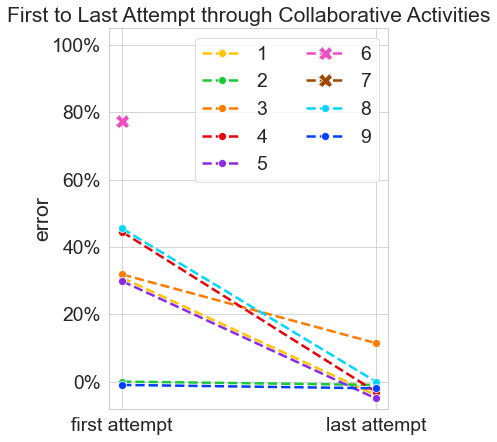

In [42]:
def plot_firstlast(comp_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    participants = [3, 8, 2, 9, 6, 7, 4, 1, 5]

    # Plot the changes from pre-test to post-test.
    xvalues = ['first attempt', 'last attempt']
    plot_comparison(
        comp_df, participants=participants, xvalues=xvalues,
        ylabel='error', verbose=verbose,
        title='First to Last Attempt through Collaborative Activities',
        yticks=True, offset=0.01, ygrid=True,
        export_file=perf_extrema_fig_file,
        getter=get_errors_from_row, ax=ax, save=save)


plot_firstlast(comp_df, verbose=False)

### Plot best submissions in collaborative activities.

In [43]:
help(plot_comparison)

Help on function plot_comparison in module utils:

plot_comparison(comparison_df, getter, participants=None, fig=None, ax=None, offset=0.01, zero_offset=0, xvalues=['1', '2'], title='', ylabel='', ylim=(-0.08, 1.05), ygrid=False, yticks=False, save=True, export_file=None, verbose=False)
    Graph the pre-test versus post-test scores.



../figures/performance_best.pdf


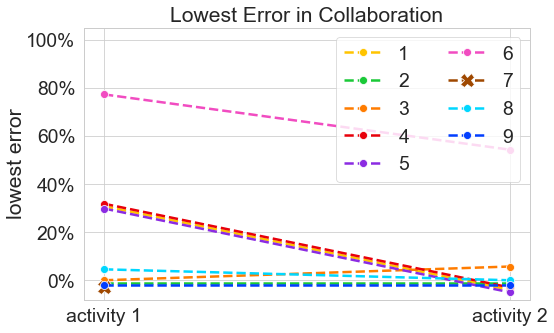

In [44]:
def plot_best(df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    participants = [3, 8, 2, 9, 6, 7, 4, 1, 5]
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(8, 5))
    
    # Plot the changes from pre-test to post-test.
    xvalues = ['activity 1', 'activity 2']
    plot_comparison(
        df, participants=participants, xvalues=xvalues,
        ylabel='lowest error', verbose=verbose,
        title='Lowest Error in Collaboration', #ve Activities',
        yticks=True, offset=0.01, ygrid=True, ax=ax,
        export_file=perf_best_fig_file,
        getter=get_errors_from_row, save=save)
    
    # fig.legend(ncol=2)


plot_best(performance_df, verbose=False)

### Together with learning outcomes

In [45]:
test_xvalues = ['pre-test', 'post-test']

In [46]:
def plot_feasible(learning_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    participants = [7, 1, 3, 8, 9, 2, 4, 5, 6]

    # Define function to retrieve and plot the feasible scores.
    def get_values_from_row(row):
        return (row.pretest_feasible, row.posttest_feasible)

    # Plot the changes from pre-test to post-test.
    plot_comparison(
        learning_df, participants=participants, xvalues=test_xvalues,
        ylabel='% feasible solutions', title='% Valid in Tests (H1.1)',
        getter=get_values_from_row,
        ax=ax, save=save, verbose=verbose)

In [47]:
def plot_optimal(learning_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    participants = [9, 1, 2, 3, 7, 4, 8, 5, 6]

    # Define function to retrieve and plot the optimal scores.
    def get_values_from_row(row):
        return (row.pretest_optimal, row.posttest_optimal)

    # Plot the changes from pre-test to post-test.
    plot_comparison(
        learning_df, participants=participants, xvalues=test_xvalues,
        ylabel='% optimal solutions', title='% Correct in Tests (H1.2)',
        getter=get_values_from_row, ax=ax,
        save=save, zero_offset=+0.025)

In [48]:
def plot_error(learning_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    participants = [2, 6, 5, 7, 4, 8, 3, 9, 1]

    # Define function to retrieve and plot the average errors.
    def get_values_from_row(row):
        return (row.pretest_error, row.posttest_error)

    # Plot the changes from pre-test to post-test.
    plot_comparison(
        learning_df, participants=participants,
        ylabel='average error', title='Error in Tests (H1.3)',
        xvalues=test_xvalues,
        yticks=True, offset=0, ygrid=True, verbose=verbose,
        getter=get_values_from_row, ax=ax, save=save)

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif


../figures/learning_outcomes.pdf


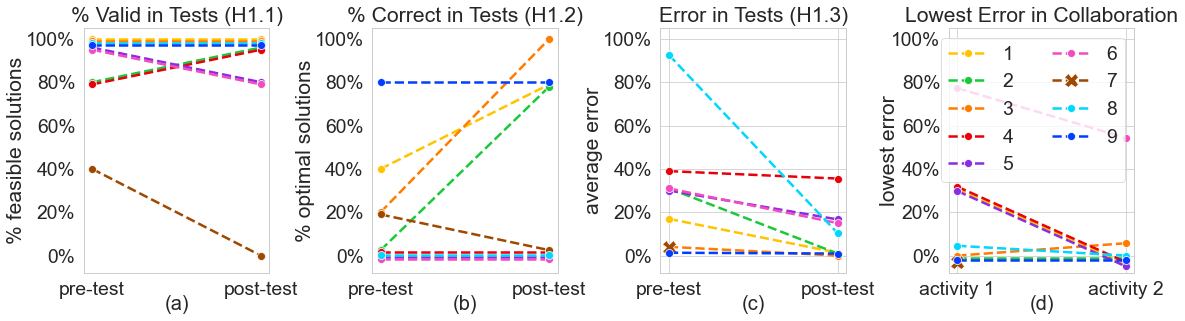

In [49]:
# fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

plot_feasible(learning_df, ax=axes[0], save=False)
plot_optimal(learning_df, ax=axes[1], save=False)
plot_error(learning_df, ax=axes[2], save=False)
plot_best(performance_df, ax=axes[3], save=False)

fig.tight_layout(pad=-0.1)  # 1)

x = 0.75
# line = plt.Line2D([x, x], [0, 1], transform=fig.transFigure, color="black")
# fig.add_artist(line)

axes[3].set_ylabel('lowest error', labelpad=-8)

for i, letter in enumerate(['a', 'b', 'c', 'd']):
    label = '({})'.format(letter)
    axes[i].text(0.5, -0.25, label, ha='center', fontsize=20)


learning_fig_file = figs_dir.joinpath('learning_outcomes.pdf')
plt.savefig(learning_fig_file, bbox_inches='tight')


print(learning_fig_file)

### Visualize the quality of actions.

In [50]:
sns.set_context('paper', font_scale=3, rc={"lines.linewidth": 2.5})

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif


../figures/quality_actions.pdf


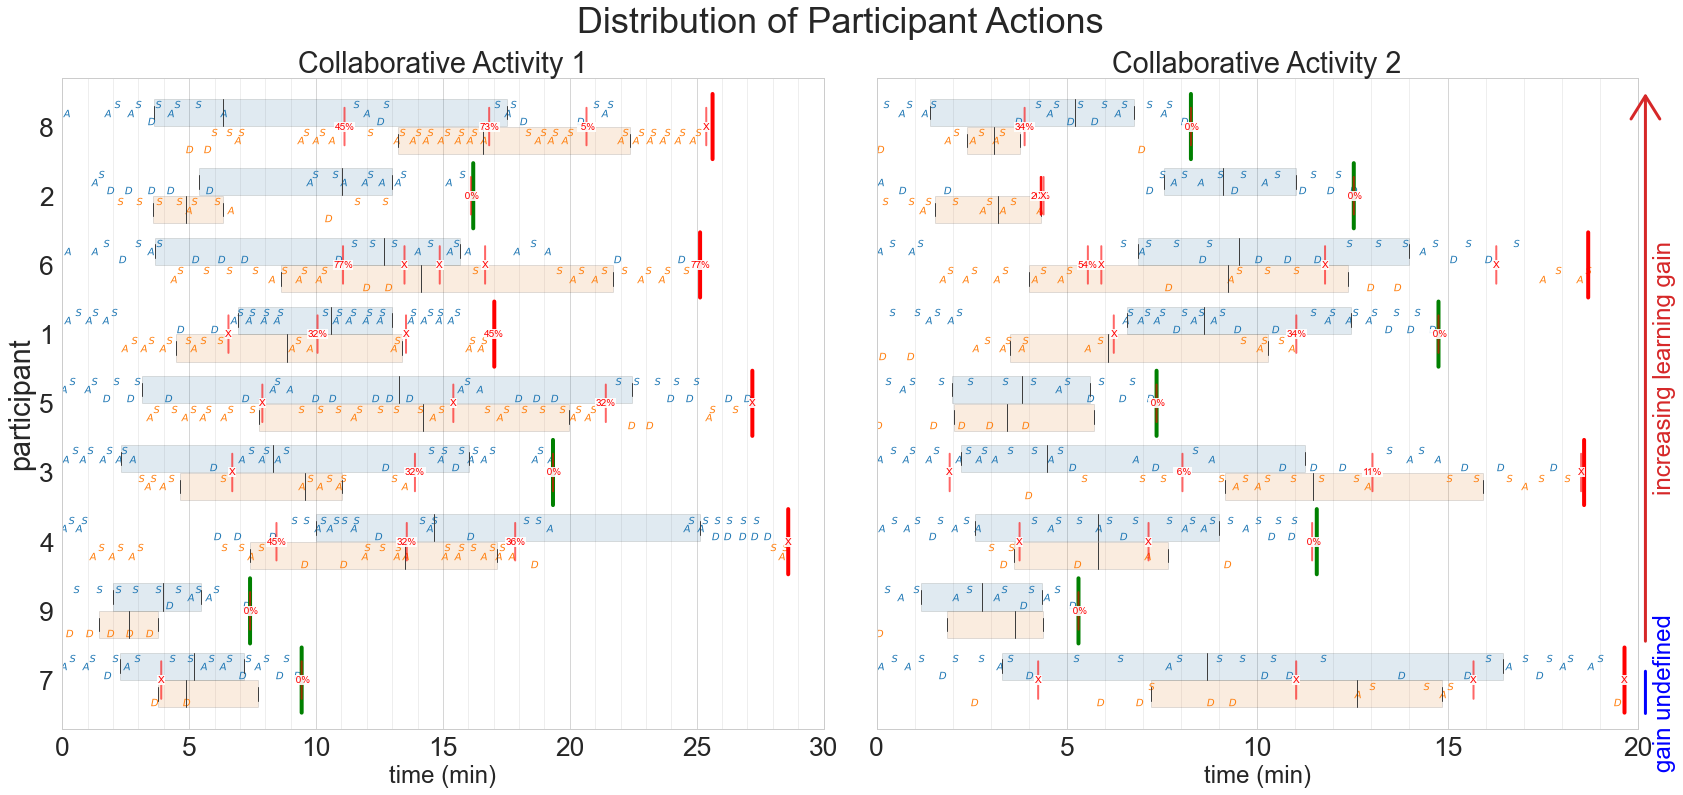

In [51]:
def plot_actions(df, x, y='participant', durations=None, order=None, fig=None, ax=None,
                 xlim=None, xlabel=None, show_ylabel=True, 
                 show_learn_groups=True, show_yticks=True):
    # Create a new figure if not supplied.
    if fig is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    if order is None:
        order = sorted(df.participant.unique())

    # Mark the end of interaction times on the plot.
    for participant, duration in durations.iteritems():
        dff = df[(df.participant == participant) &
                 (df.time_in_activity == duration)].copy()
        if dff.iloc[0]['error'] == 0.0:
            c = 'g'
        else:
            c = 'r'
        pos = duration  # row['duration (secs)']
        yval = order.index(str(participant))
        props = dict(arrowstyle='-', alpha=1.0, linewidth=4, color=c)
        ax.annotate(
            '', xy=(pos, yval+0.5), xytext=(pos, yval-0.5), xycoords='data',
            arrowprops=props)  # color='green'

    # # Mark the common duration with a vertical line.
    # # common_duration = df.groupby('participant')['duration'].apply(np.max).min()
    # common_duration = durations.min()
    # ax.axvline(common_duration, ls='--', color='green')

    # Annotate the submission costs on the plot.
    for participant in df.participant.unique():
        dff = df[df.participant == participant].copy()
        dff = dff[[isinstance(action, SubmitAction)
                   for action in dff['action']]]
        yval = order.index(str(participant))
        for i, row in dff.iterrows():
            arrow_start, arrow_end = 0, 0
            # text_pos = row['scaled_end']
            text_pos = row['time_in_activity']

            is_human = row['action'].agent is Agent.HUMAN

            val = row['error']
            if np.isnan(val):
                s = 'X'  # 'UNDEF'
            else:
                s = '{:2.0f}%'.format(100 * val)
            offset = 0
            color = 'b' if is_human else 'r'
            props = dict(arrowstyle='-', alpha=0.6, linewidth=2, color=color)
            ax.annotate(
                '', xy=(text_pos, yval+0.3), xytext=(text_pos, yval-0.3),
                xycoords='data', arrowprops=props)  # color='blue',
            t = ax.annotate(
                s, xy=(text_pos, yval+offset), backgroundcolor='w',
                fontsize=10, xycoords='data', color=color, ha='center', va='center')
            t.set_bbox(
                dict(fc='w', alpha=0.9, ec='none', boxstyle='square,pad=0.05'))

    # # Plot utterances by marking their end times.
    palette = sns.color_palette()
    colors = list(palette)

    markersize = 54 #48

    offset1, offset2 = 0.1, 0  # -0.2, -0.1
    offset1, offset2 = -0.2, -0.1
    dff = df.copy()
    dff = dff.dropna(subset=['is_optimal'])
    bp = sns.boxplot(
        x=x, y=y, order=order, hue='is_optimal',
        palette={True: colors[0], False: colors[1]},
        hue_order=[True, False], boxprops=dict(alpha=.15), linewidth=1,
        showfliers=False, whis=0,
        data=dff, ax=ax)

    # Plot optimal actions times of the participant.
    dff = df.copy()
    dff = dff.dropna(subset=['is_optimal'])
    dff = dff[dff.is_human]
    dff = dff[dff.is_optimal]
    offset3 = 0.12
    for participant in order:
        index = order.index(str(participant))
        dfff = dff[dff.participant == str(participant)]
        
        # optimal suggestions
        xs = dfff[[isinstance(action, SuggestPickAction)
                   for action in dfff['action']]][x] # 'P'
        ys = index + offset1 - offset3
        sns.scatterplot(
            x=xs, y=ys, color=colors[0], marker='$S$', linewidth=0,
            s=markersize, ax=ax)
        
       # optimal agreements 
        xs = dfff[[isinstance(action, AgreeAction)
                   for action in dfff['action']]][x]
        ys = index + offset1
        sns.scatterplot(
            x=xs, y=ys, color=colors[0], marker='$A$', linewidth=0,
            s=markersize, ax=ax)
       
        # optimal disagreements 
        xs = dfff[[isinstance(action, DisagreeAction)
                   for action in dfff['action']]][x]
        ys = index + offset1 + offset3
        sns.scatterplot(
            x=xs, y=ys, color=colors[0], marker='$D$', linewidth=0,
            s=markersize, ax=ax)
            
    # Plot suboptimal actions times of the participant.
    dff = df.copy()
    dff = dff[dff.is_human]
    dff = dff.dropna(subset=['is_optimal'])
    dff = dff[dff.is_optimal.eq(False)]
    for participant in order:
        index = order.index(str(participant))
        dfff = dff[dff.participant == str(participant)]
        
        # xs = dff[dff.participant == str(participant)][x]
        # ys = index - offset1
        # sns.scatterplot(
        #     x=xs, y=ys, color=colors[1], marker='X', linewidth=0,
        #     s=markersize, ax=ax)
        
        # suboptimal suggestions
        xs = dfff[[isinstance(action, SuggestPickAction)
                   for action in dfff['action']]][x] # 'P'
        ys = index - offset1 - offset3
        sns.scatterplot(
            x=xs, y=ys, color=colors[1], marker='$S$', linewidth=0,
            s=markersize, ax=ax)
        
       # suboptimal agreements 
        xs = dfff[[isinstance(action, AgreeAction)
                   for action in dfff['action']]][x]
        ys = index - offset1
        sns.scatterplot(
            x=xs, y=ys, color=colors[1], marker='$A$', linewidth=0,
            s=markersize, ax=ax)
       
        # suboptimal disagreements 
        xs = dfff[[isinstance(action, DisagreeAction)
                   for action in dfff['action']]][x]
        ys = index - offset1 + offset3
        sns.scatterplot(
            x=xs, y=ys, color=colors[1], marker='$D$', linewidth=0,
            s=markersize, ax=ax)
        
        
    # # Set x-axis properties.
    # if xlabel is not None:
    #     ax.set_xlabel(xlabel, fontsize=18)

    # Set y-axis properties.
    if not show_ylabel:
        ax.set_ylabel('')
    if not show_yticks:
        # ax.set_yticks([], [])
        ax.set_yticks([])  # values
        ax.set_yticklabels([])  # labels

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.grid(True, alpha=0.4, which='minor')

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    # Annotate the groups of learning outcomes.
    if show_learn_groups:
        l = [0] + ['9'] + [1]  # + seps +
        x, offset = 1.02, 0.02
        labels = ['increasing learning gain', 'gain undefined']
        color_list = [colors[3], 'b', colors[2]]
        for i, (previous, current) in enumerate(zip(l, l[1:])):
            # print(i, previous, current)
            if isinstance(previous, str):
                previous = (order.index(previous)+1) / len(order)
            if isinstance(current, str):
                current = (order.index(current)+1) / len(order)
            previous += offset
            current -= offset
            previous, current = 1 - previous, 1 - current
            style = '-'
            x = 1.01
            if i == 0:
                # show the increasing direction
                style = '->,head_length=0.8,head_width=0.5'
            ax.annotate(
                '', xy=(x, previous), xytext=(x, current),
                #             xy=(1, 1), xytext=(1, 0.2),
                xycoords='axes fraction',
                arrowprops=dict(arrowstyle=style, linewidth=3, color=color_list[i]))
            s = labels[i]
            x = 1.02
            t = ax.annotate(
                s, xy=(x, (previous+current)/2), fontsize=24, rotation=90,
                xycoords='axes fraction', color=color_list[i], ha='left', va='center')

    # Set x-axis properties.
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_xticks(np.arange(xlim[0], xlim[1]+1, 300))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.0f}'.format(x/60)))
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=24)

    return fig, ax


df = transitions_df.copy()
df.participant = df.participant.astype(str)
df = df[df.activity.isin(['collaboration-1'])]

# Order alphanumerical.
# order = sorted(df.participant.unique())
# Order by duration.
durations = df.groupby('participant')[
    'time_in_activity'].apply(np.max).sort_values()
order = list(durations.sort_values().index)

# Order by learning.
order = list([str(p) for p in learning_df.sort_values(
    'learning_gain', ascending=False).index])

# Begin plotting.
# fig, ax = plt.subplots(figsize=(16, 12))
fig, axs = plt.subplots(1, 2, figsize=(24, 12))
# fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)

plot_actions(df, 'time_in_activity', durations=durations,  xlabel='time (min)',
             order=order, fig=fig, ax=axs[0], xlim=[0, 30*60],
            show_learn_groups=False)


df = transitions_df.copy()
df.participant = df.participant.astype(str)
df = df[df.activity.isin(['collaboration-2'])]
durations = df.groupby('participant')[
    'time_in_activity'].apply(np.max).sort_values()
plot_actions(df, 'time_in_activity', durations=durations, xlabel='time (min)',
             order=order, fig=fig, ax=axs[1], xlim=[0, 20*60],
             show_yticks=False, show_ylabel=False)

# fig.suptitle('Dynamics of Interaction in Collaborative Activities', y=.94, size=28) #02) #0.92)  # .98)
fig.suptitle("Distribution of Participant Actions", y=.94, size=36) #02) #0.92)  # .98)

size = 24
axs[0].set_title('Collaborative Activity 1') #, size=size)
axs[1].set_title('Collaborative Activity 2') #, size=size)
# axs[0].set_xlabel('time (mins)')
# axs[1].set_xlabel('time (mins)')

fig.tight_layout()

# Export as pdf - vector graphics.
fig.savefig(action_quality_fig_file, bbox_inches='tight')
print(action_quality_fig_file)

In [52]:
# dff.time.iloc[-1] / 60

In [53]:
df = transitions_df.copy()
df.participant = df.participant.astype(str)
dff = df.copy()
# dff = dff[dff.is_human]

participant = 9
dff = dff[dff.participant == str(participant)]
dff = dff[dff.activity == 'collaboration-1']

dff #.head(20)
# dff = dff[dff.time> 14.60]
# dff.loc[80] #.possible_optimals
# dff.tail(20)

,participant,time,activity,state,next_state,action,attempt_no,cost,opt_cost,error,is_submission,is_mst,is_spanning,possible_optimals,is_optimal,time_in_activity,time_in_activity_frac,is_human
64,9,658.174413,collaboration-1,"Situation(Network(|E'|=0 in G(|V|=10, |E|=20))...","Situation(Network(|E'|=0+1 in G(|V|=10, |E|=20...","Action(suggest-pick(0,3),Robot)",1,0,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",True,0.0,0.0,False
65,9,674.981552,collaboration-1,"Situation(Network(|E'|=0+1 in G(|V|=10, |E|=20...","Situation(Network(|E'|=0 in G(|V|=10, |E|=20))...","Action(disagree,Human)",1,0,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",False,16.807138,0.037849,True
66,9,689.779325,collaboration-1,"Situation(Network(|E'|=0 in G(|V|=10, |E|=20))...","Situation(Network(|E'|=0+1 in G(|V|=10, |E|=20...","Action(suggest-pick(1,2),Human)",1,0,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",True,31.604912,0.071174,True
67,9,702.629346,collaboration-1,"Situation(Network(|E'|=0+1 in G(|V|=10, |E|=20...","Situation(Network(|E'|=1 in G(|V|=10, |E|=20))...","Action(suggest-pick(1,2),Robot)",1,0,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",True,44.454932,0.100112,False
68,9,711.832281,collaboration-1,"Situation(Network(|E'|=1 in G(|V|=10, |E|=20))...","Situation(Network(|E'|=1+1 in G(|V|=10, |E|=20...","Action(suggest-pick(2,3),Robot)",1,2,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",True,53.657868,0.120837,False
69,9,722.111913,collaboration-1,"Situation(Network(|E'|=1+1 in G(|V|=10, |E|=20...","Situation(Network(|E'|=1 in G(|V|=10, |E|=20))...","Action(disagree,Human)",1,2,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",False,63.9375,0.143986,True
70,9,744.640136,collaboration-1,"Situation(Network(|E'|=1 in G(|V|=10, |E|=20))...","Situation(Network(|E'|=1+1 in G(|V|=10, |E|=20...","Action(suggest-pick(8,9),Human)",1,2,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",True,86.465723,0.194719,True
71,9,757.909408,collaboration-1,"Situation(Network(|E'|=1+1 in G(|V|=10, |E|=20...","Situation(Network(|E'|=2 in G(|V|=10, |E|=20))...","Action(suggest-pick(8,9),Robot)",1,2,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",True,99.734995,0.224602,False
72,9,767.338148,collaboration-1,"Situation(Network(|E'|=2 in G(|V|=10, |E|=20))...","Situation(Network(|E'|=2+1 in G(|V|=10, |E|=20...","Action(suggest-pick(9,1),Robot)",1,4,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",True,109.163734,0.245835,False
73,9,770.052764,collaboration-1,"Situation(Network(|E'|=2+1 in G(|V|=10, |E|=20...","Situation(Network(|E'|=2 in G(|V|=10, |E|=20))...","Action(disagree,Human)",1,4,22,NaN,False,False,False,"{(3, 1, 0, 2, 5, 4, 7, 6, 9, 8), (3, 1, 0, 2, ...",False,111.87835,0.251948,True


In [54]:
dff.columns

dff[['state', 'action', 'is_optimal', 'possible_optimals']].tail(93)

l = list(dff.loc[96].possible_optimals)
# l[0].edges()
l

In [55]:
dff.loc[97].state.network.is_mst() #subgraph.edges()

True

In [56]:
dff.loc[97].state.network.is_spanning() 

True

In [57]:
g = dff.loc[97].state.network.subgraph
g.number_of_nodes(), g.number_of_edges(), g.edges()

(10,
 9,
 EdgeView([(1, 2), (1, 3), (2, 8), (6, 4), (6, 7), (4, 5), (4, 9), (3, 0), (8, 9)]))

In [58]:
# dff.loc[93] #.state.network.subgraph.edges()

In [59]:
# row = dff.loc[123]
# row.state.network.suggested_edge


# row.next_state.network.subgraph.edges

In [60]:
# row = dff.loc[131]
# row.next_state.network.subgraph.edges, row.next_state.network.is_spanning()

In [61]:
# learning_df.sort_values('learning_gain', ascending=False)
# # df[df.participant == '6']

In [62]:
# # transitions_df.head()
# df = transitions_df.copy()
# # df = df[df.activity.isin(['collaboration-1'])]
# df = df[df.participant.isin([1])]
# df

In [63]:
# def is_submitting(action):
#     return isinstance(action, SubmitAction) or isinstance(action, AttemptSubmitAction)

# df = transitions_df.copy()
# df['is_submitting'] = [is_submitting(a) for a in df.action]
# df[df.is_submitting]

In [64]:
# df = transitions_df.copy()
# df[df.participant == 8]

In [65]:
### Qualitative Analysis

# participant = 1
# columns = ['time', 'activity', 'action', 'is_optimal']

# df = transitions_df.copy()


# df = df[df.participant == participant]
# df = df[columns]
# df = df[df.activity.isin(['collaboration-{}'.format(i) for i in range(1, 3)])]

# # df